In [1]:
# NaN = 1 to drop NaN values in dataframe, else NaN = 0
NaN = 1

# correlated = 1 to drop correlated features in dataframe, else correlated = 0
correlated = 1

# correlation lower bound to drop features
corr_bound = 0.95
# minimum difference in IV to drop feature based on correlation bound
iv_diff = 0.1 #Feat_sum.loc[:,"Total_IV"].std()

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import os.path
import rpy2
import scorecardpy as sc
from scorecardpy import info_value 
import seaborn as seabornInstance 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn import feature_selection
from sklearn.feature_selection import RFE, RFECV, mutual_info_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

In [3]:
f = os.path.expanduser( "~/Documents/Vodacom/data/df_raw_final.pkl" )

df = pd.read_pickle(f)

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
#new dataframe after dropping all values with NaN
dfclean = df.dropna( subset = ['target_label'] )

In [6]:
#replace all strings "yes", "no", "maybe" with integers 0, 1, 2 
dfclean = dfclean.replace( to_replace = "yes", value = 1 )
dfclean = dfclean.replace( to_replace = "no", value = 0 )
dfclean = dfclean.replace( to_replace = "maybe", value = 2 )

In [7]:
# remove all rows with target_label = 2 ("maybe")
dfclean = dfclean[ dfclean.target_label != 2 ]

In [8]:
# dfclean.isna().sum()

In [9]:
# remove all columns that are targets 
for feature in dfclean :
    
    if (dfclean[feature].isna().sum() > 100) :
        dfclean = dfclean.drop( columns = feature )

In [10]:
# remove column geometry due to string error with conversion
dfclean_nogeo = dfclean.drop( columns = "geometry")

# add randomized feature
# dfclean_nogeo['randfeature'] = np.random.normal(size = dfclean_nogeo.shape[0])

In [11]:
# plt.hist(dfclean_nogeo.randfeature, 100)
# plt.show()

Column 'geometry' in dataframe causes unwanted errors.
Initialize new dataframe without the 'geometry' column.
Assumption that the 'geometry' column causes more issues than has relevance for model.

In [12]:
Feat_typ = {}
Num_typ = {}

num_list = []
cat_list = []
index_list = []

j = 1

# for loop to identify feature types

for i, feature in enumerate( dfclean_nogeo ):
    
    if ( dfclean_nogeo[ feature ].dtype == 'float64' or dfclean_nogeo[ feature ].dtype == 'int64'):
        
        value_list = dfclean_nogeo[feature].values
        length_values_list = []
        
# for loop identifying if all items in a given feature have the same number of characters
# if they do, identify feature as a category
        
        for item in value_list:
            
            length_values_list.append( len( str( item ) ) )

# CODE = true if number of characters in values of all features are the same            
            
        CODE = ( len( set( length_values_list ) ) == 1)
        
    if (dfclean_nogeo[feature].dtype == 'object' or CODE):     

        Feat_typ[feature] = [i,"cat"]
        index_list.append(feature)
        if (feature != 'target_label') :
            
            cat_list.append(feature)
    
    else:
        
        Feat_typ[feature] = [i, "num"]
        Num_typ[feature] = [j, "num"]
        num_list.append(feature)
        index_list.append(feature)
        j = j + 1
    
    # adding the 'target_label' column to num_list    
    
    if feature == "target_label":

        num_list.append( feature )


big explanation here probs

In [13]:
%load_ext rpy2.ipython

Activates the use of R in the Jupyter Notebook

In [14]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Brute force fix for kernel dying on Mac, Error15

In [15]:
%%R -i dfclean_nogeo -i num_list -o cuts

library(smbinning)
library(foreach)
library(doParallel)


comb <- function(...){
    mapply('cbind', ..., SIMPLIFY = FALSE)
}

no_cores <- detectCores()
registerDoParallel(cores = 4)

numg_list = c()
cutsgood = c()

Features <- names(dfclean_nogeo)[1:ncol(dfclean_nogeo)]

i = 1
j = 1

ptime <- system.time({

 cuts = foreach( col = Features, .combine = comb, .packages = 'smbinning')  %dopar%  {

    sbin = smbinning( dfclean_nogeo, 'target_label', col )
            
       if ( !is.na( sbin[ 'bands' ] ) ) {
        
            cutsgood[[i]] <- sbin$bands[ -length( sbin$bands ) ]
            numg_list[i] = col
            i = i + 1
           
        } 
     
        # adding target_label to numg_list
        if ( col == "target_label" ) {

            numg_list[i] = col

        }
     
     return(list(numg_list, cutsgood))
     
    }
    
})[3]
print(paste("Time taken for smbinning =", ptime, "seconds"))

R[write to console]: Loading required package: sqldf

R[write to console]: Loading required package: gsubfn

R[write to console]: Loading required package: proto

R[write to console]: Loading required package: RSQLite

R[write to console]: Loading required package: partykit

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: libcoin

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: Formula

R[write to console]: Loading required package: iterators

R[write to console]: Loading required package: parallel



[1] "Time taken for smbinning = 12.021 seconds"


In [16]:
# create a list for numg_list from an R vector
cuts = list(cuts)

In [17]:
# creating dictionary of value cutsgood
cutsg_dic = dict( zip( cuts[0], cuts[1] ) )

The woebin function creates IV tables for all numerical features in dataframe. It uses smbinning's cut values for the bins for all numerical features within cutsg_dic, all other numerical features have bins cut by the woebin function. 
This is due to the assumption that smbinning utilizes a more accurate cut value for the bins and woebinning is the second best option available to us. 

In [18]:
# remove all columns that are targets 
#for feature in dfclean :
    
   # if (dfclean[feature] = cat_list) :
dfclean_nogeo = dfclean_nogeo.drop( columns = cat_list )

In [19]:
# all_iv = sc.woebin( dfclean_nogeo.loc[ :, index_list ],
#                    y = "target_label", breaks_list = cutsg_dic, positive = 0, bin_num_limit = 20 )

In [20]:
# information values of all numerical features
num_iv = sc.woebin( dfclean_nogeo.loc[ :, num_list ],
                   y = "target_label", breaks_list = cutsg_dic, positive = 0, bin_num_limit = 20 )

[INFO] creating woe binning ...


/opt/anaconda3/lib/python3.7/site-packages/scorecardpy/condition_fun.py:113: UserWarning: The positive value in "target_label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))
/opt/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:725: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  binning = pd.concat(bin_list, keys=bin_list.keys()).reset_index()\
/opt/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:725: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [21]:
# new dataframe summarizing features
Feat_sum = pd.DataFrame( dfclean_nogeo.dtypes )

i = 0

for feature in dfclean_nogeo:
    
    Feat_sum.loc[ feature,"Unique" ] = dfclean_nogeo[ feature ].nunique()
    Feat_sum.loc[ feature, "NaNs" ] = dfclean_nogeo[ feature ].isna().sum()
    i = i + 1

Creating a dataframe to summarize each feature

In [22]:
# IV values of all categorical features in dataframe
#cat_iv = sc.info_value.iv( dfclean_nogeo.loc[ :, cat_list ], y = "target_label" )

In [23]:
# # changing the headings of the dataframe cat_iv
# cat_iv = cat_iv.rename( columns = { 'variable':'', 'info_value': 'Total_IV' } )

# cat_iv = cat_iv.set_index('')

In [24]:
# # adding iv values of numerical features to summary dataframe
# for feature in dfclean_nogeo.loc[ :, num_list ]:
    
#     if ( feature != 'target_label') :
        
#         Feat_sum.loc[ feature,'Total_IV' ] = num_iv[ feature ].total_iv[ 1 ]

In [25]:
# # adding iv values of categorical features to summary datframe
# for feature in dfclean_nogeo.loc[ :, cat_list ]:
    
#     if ( feature != 'target_label' ) :
        
#         Feat_sum.loc[ feature,'Total_IV' ] = cat_iv.loc[ feature, 'Total_IV' ]
        

In [26]:
# adding iv values of numerical features to summary datframe
for feature in dfclean_nogeo.loc[ :, num_list ]:
    
    if ( feature != 'target_label' ) :
        
        Feat_sum.loc[ feature,'Total_IV' ] = num_iv[ feature ].total_iv[ 1 ]
        

In [27]:
# with open('Feat_sum.data', rb) as filehandle :
# Feat_sum.to_csv('Feat_sum.csv')

In [28]:
# df_final.to_csv('df_final.csv')

In [29]:
Feat_sum.sort_values('Total_IV', ascending = False).head(10)

,0,Unique,NaNs,Total_IV
P_NLI1,float64,1696.0,0.0,2.447159
computer_perc,float64,1516.0,18.0,2.312888
AREA_KM2,float64,2129.0,0.0,2.115097
internet_access_from_home,float64,1484.0,18.0,2.037663
D_DOMESTIC_KM2,float64,1883.0,0.0,2.011477
r_307_601___r_614_400,float64,1365.0,18.0,1.917416
pd,float64,1787.0,18.0,1.853180
internet_access_from_work,float64,1386.0,18.0,1.684346
r_614_001___r_1_228_800,float64,1263.0,18.0,1.640215
tv_perc,float64,1260.0,18.0,1.621314


In [30]:
# creating correlation matrix
cor = dfclean_nogeo.corr()

# cor.style.background_gradient(cmap = 'coolwarm')

In [31]:
# joining Feat_sum matrix and correlation matrix
cor = cor.join(Feat_sum.Total_IV, how = 'outer')

In [32]:
rem_feat = []
check_feat = []

for feature, correl in cor.iteritems():
    
    #for each feature
    for i in np.arange(len(correl.values)):
    
    # run through each row of cor
        
        if (abs(correl[i]) > corr_bound and correl.index[i] != feature and feature != "Total_IV"):
    #if the correlation is high and less than one and ignore total IV
            
            if (cor.loc[correl.index[i], "Total_IV"] - cor.loc[feature, "Total_IV"] > iv_diff):
    #if the IV of the row feature is more than 0.1 greater than the IV of the column feature, add the comun to the remove list
#                 print("row ",correl.index[i],"   is bigger than column     ", feature)
                rem_feat.append(feature)
            
            elif(cor.loc[correl.index[i], "Total_IV"] - cor.loc[feature, "Total_IV"] > 0):
    #if the features have very similar IVs, add them to the check list
                check_feat.append([feature, correl.index[i]])

rem_feat = list(dict.fromkeys(rem_feat))     #original order

# rem_feat =  list(set(rem_feat))            #fastest order
# rem_feat =  set(rem_feat)                  #alphabetical order
# rem_feat =  rem_feat                       #with duplicates


In [33]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

# drop all rows containing NaN values 
if (NaN == 1):
    
    df_final_noNaN = dfclean_nogeo.dropna()
    
else:
        
    df_final_noNaN = dfclean_nogeo

In [34]:
# drop columns based off of correlation comparison
if (correlated == 1) :
    
    df_final_noNaN = df_final_noNaN.drop(columns = rem_feat)

In [35]:
#cat_woe = sc.woebin( dfclean_nogeo.loc[ :, cat_list ], y = "target_label", bin_num_limit = 20 )
#df_final2 = sc.woebin_ply(df_final, cat_woe)

In [36]:
# transforming data table to WOE values
df_final = sc.woebin_ply(df_final_noNaN, num_iv)

[INFO] converting into woe values ...


# IV list maximization


In [37]:
for i, feat in enumerate(Feat_sum.iterrows()):
    Feat_sum = Feat_sum.rename(index = {feat[0]: feat[0] + "_woe"})

In [38]:
Feat_sum = Feat_sum.loc[df_final.columns]
Feat_sum = Feat_sum.sort_values("Total_IV", ascending = False)
Feat_sum.drop(Feat_sum.tail(1).index, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [39]:
# no_feat_acc = []
# for no_feat in np.arange(len(Feat_sum)):
    
#     used_feat = list(Feat_sum[0:no_feat+1].index)
#     df_final_X = df_final.loc[:,used_feat]
#     df_final_Y = pd.DataFrame(df_final.target_label)
#     X_train, X_test, y_train, y_test = train_test_split(df_final_X, df_final_Y,
#                                                        test_size = 0.3,stratify = df_final_Y,
#                                                        random_state = 40)
#     logreg = LogisticRegression()
#     logreg.fit(X_train, y_train)
#     y_pred = logreg.predict(X_test)
#     no_feat_acc.append([logreg.score(X_test, y_test), no_feat, used_feat])
    

In [40]:
#max(no_feat_acc)

# WOE and not WOE 

In [41]:
df_final_x_woe = df_final.drop(["target_label"], axis = 1)
df_final_y_woe = pd.DataFrame(df_final.target_label)

df_final_x = df_final_noNaN.drop(["target_label"], axis = 1)
df_final_y = pd.DataFrame(df_final_noNaN.target_label)

In [42]:
X_train_woe, X_test_woe, y_train_woe, y_test_woe = train_test_split(df_final_x_woe, df_final_y_woe, 
                                                test_size = 0.3, stratify = df_final_y_woe,
                                                random_state = 40)

X_train, X_test, y_train, y_test = train_test_split(df_final_x, df_final_y, 
                                                test_size = 0.3, stratify = df_final_y,
                                                random_state = 40)

In [43]:
regressor_woe = LogisticRegression()  
regressor_woe.fit(X_train_woe, y_train_woe)
  
y_pred_woe = regressor_woe.predict(X_test_woe)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
regressor = LogisticRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
select_feature_woe = mutual_info_classif(X_train_woe, y_train_woe)

select_feature = mutual_info_classif(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
selected_features_df_woe = pd.DataFrame({'Features': list(X_train_woe.columns),
                                     'Scores': select_feature_woe})
selected_features_df_woe = selected_features_df_woe.sort_values(by = 'Scores', ascending = False)

selected_features_df = pd.DataFrame({'Features': list(X_train.columns),
                                     'Scores': select_feature})
selected_features_df = selected_features_df.sort_values(by = 'Scores', ascending = False)

# Mutual Information

In [47]:
# no_feat_acc = []
# for no_feat in np.arange(len(selected_features_df_woe)):
    
#     used_feat = list(selected_features_df_woe.iloc[0:no_feat+1,0])
#     df_final_X = df_final.loc[:,used_feat]
#     df_final_Y = pd.DataFrame(df_final.target_label)
#     X_train, X_test, y_train, y_test = train_test_split(df_final_X, df_final_Y,
#                                                        test_size = 0.3,stratify = df_final_Y,
#                                                        random_state = 40)
#     logreg = LogisticRegression()
#     logreg.fit(X_train, y_train)
#     y_pred = logreg.predict(X_test)
#     no_feat_acc.append([logreg.score(X_test, y_test), no_feat, used_feat])
    

In [48]:
#max(no_feat_acc)

In [49]:
df_final.columns.nunique()

84

In [50]:
confusion_matrix_woe = metrics.confusion_matrix(y_test_woe, y_pred_woe)
print(confusion_matrix_woe)

[[245  41]
 [ 37 311]]


In [51]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[194  92]
 [ 36 312]]


In [52]:
score_woe = regressor_woe.score(X_test_woe, y_test_woe)
print(score_woe)

0.8769716088328076


In [53]:
score = regressor.score(X_test, y_test)
print(score)

0.7981072555205048


In [54]:
print(classification_report(y_test_woe, y_pred_woe))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       286
           1       0.88      0.89      0.89       348

    accuracy                           0.88       634
   macro avg       0.88      0.88      0.88       634
weighted avg       0.88      0.88      0.88       634



In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75       286
           1       0.77      0.90      0.83       348

    accuracy                           0.80       634
   macro avg       0.81      0.79      0.79       634
weighted avg       0.80      0.80      0.79       634



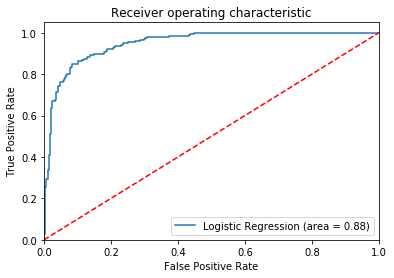

In [56]:
logit_roc_auc_woe = roc_auc_score(y_test_woe, regressor_woe.predict(X_test_woe))
fpr, tpr, thresholds = roc_curve(y_test_woe, regressor_woe.predict_proba(X_test_woe)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_woe)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

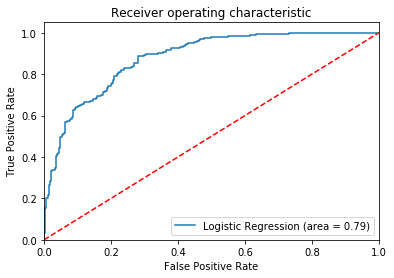

In [57]:
logit_roc_auc = roc_auc_score(y_test, regressor.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, regressor.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [58]:
# rfe_woe = RFE( random_state = 101 )
svc_woe = SVC(kernel="linear")
rfecv_woe = RFECV( estimator = svc_woe, step = 1, cv = StratifiedKFold(10), scoring = 'accuracy', n_jobs = 4 )
rfecv_woe.fit( X_test_woe, y_test_woe )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                    decision_function_shape='ovr', degree=3,
                    gamma='auto_deprecated', kernel='linear', max_iter=-1,
                    probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=4, scoring='accuracy', step=1,
      verbose=0)

In [59]:
rfe = RFE( random_state = 101 )
#svc = SVC(kernel="linear")
rfecv = RFECV( estimator = rfe, step = 1, cv = StratifiedKFold(10), scoring = 'accuracy', n_jobs = 4 )
rfecv.fit( X_test, y_test )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators='warn', n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=4, scoring='accuracy', step=1,
      verbose=0)

In [60]:
if (correlated == 1):
    print('Highly correlated features removed')
print('Optimal number of features with woe: {}'.format(rfecv_woe.n_features_))
print('Out of total: ', selected_features_df_woe.Features.nunique(), ' features')
print('Score', ' = ' ,score_woe)

Highly correlated features removed
Optimal number of features with woe: 17
Out of total:  83  features
Score  =  0.8769716088328076


In [61]:
optimal_features_df_woe = pd.DataFrame({'Features': list(X_train_woe.columns),
                                     'Scores': rfecv_woe.support_})
optimal_features_df_woe.loc[optimal_features_df_woe['Scores'] == True]

,Features,Scores
0,AREA_KM2_woe,True
4,P_NLI9_woe,True
5,P_NLI3_woe,True
6,dvd_perc_woe,True
7,HH_NLI4_woe,True
19,internet_access_grand_total_woe,True
20,internet_access_from_home_woe,True
43,r_38_201___r_76_400_woe,True
46,AGE75_79_woe,True
48,r_153_801___r_307_600_woe,True


In [62]:
if (correlated == 1):
    print('Highly correlated features removed')
print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Out of total: ', selected_features_df.Features.nunique(), ' features')
print('Score', ' = ' ,score)

Highly correlated features removed
Optimal number of features: 38
Out of total:  83  features
Score  =  0.7981072555205048


In [63]:
optimal_features_df = pd.DataFrame({'Features': list(X_train.columns),
                                     'Scores': rfecv.support_})
optimal_features_df.loc[optimal_features_df['Scores'] == True]

,Features,Scores
1,W_M_INC17,True
7,P_NLI7,True
8,P_NLI8,True
9,P_NLI9,True
10,HH_NLI1,True
11,HH_NLI2,True
17,HH_NLI9,True
20,AREA_KM2,True
21,POP_KM2,True
23,D_POP_CHAN,True


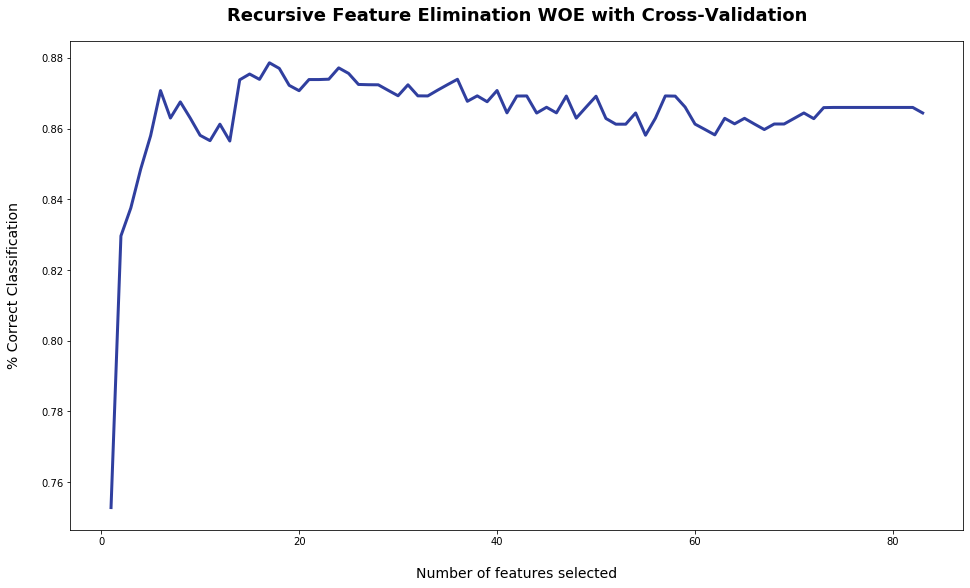

In [64]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination WOE with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv_woe.grid_scores_) + 1), rfecv_woe.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

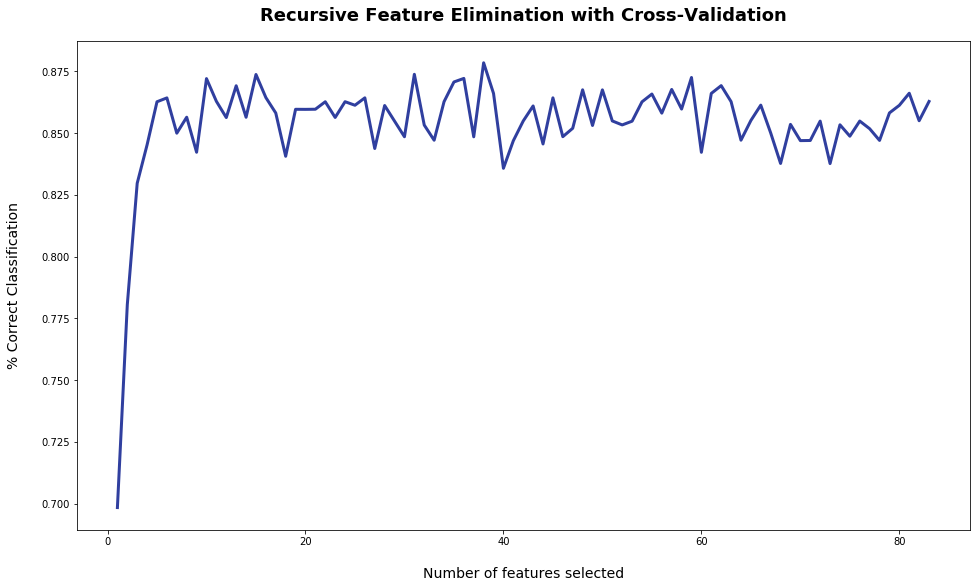

In [65]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [66]:
print(np.where(rfecv.support_ == False)[0])

[ 0  2  3  4  5  6 12 13 14 15 16 18 19 22 24 26 30 31 32 33 34 36 37 39
 45 47 50 51 54 55 57 59 61 62 63 64 65 66 67 68 69 70 77 78 80]


In [67]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 38


In [68]:
x = rfecv_woe.estimator_.feature_importances_
x

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [ ]:
# dset = pd.DataFrame()
# dset['attr'] = X_train_woe.columns
# dset['importance'] = rfecv_woe.estimator_.feature_importances_

# dset = dset.sort_values(by='importance', ascending=False)


# plt.figure(figsize=(16, 14))
# plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
# plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
# plt.xlabel('Importance', fontsize=14, labelpad=20)
# plt.show()

In [ ]:
#help(RFC)